In [ ]:
# default_exp core

# core

> Functions to split overlapping boundig boxes.

In [ ]:
#hide
from nbdev.showdoc import *
from nbdev.export import notebook2script

In [ ]:
#export
import numpy as np 
import pandas as pd 
import geopandas as gpd
import shapely
from shapely.geometry import Polygon, LineString
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
#export
def box2polygon(x):
    return Polygon([(x[0], x[1]), (x[0]+x[2], x[1]), (x[0]+x[2], x[1]+x[3]), (x[0], x[1]+x[3])])

In [ ]:
df = pd.read_csv('data/train.csv')
boxes = df.groupby('image_id').agg({'bbox' : lambda x : list(x)})
box = boxes.iloc[2]
bbox = np.array([eval(l) for l in box.bbox]).astype(int).tolist()
gdf = gpd.GeoDataFrame({'geometry': [box2polygon(b) for b in bbox]})
gdf.head()

,geometry
0,"POLYGON ((437.000 988.000, 535.000 988.000, 53..."
1,"POLYGON ((309.000 527.000, 419.000 527.000, 41..."
2,"POLYGON ((414.000 595.000, 499.000 595.000, 49..."
3,"POLYGON ((238.000 949.000, 350.000 949.000, 35..."
4,"POLYGON ((442.000 56.000, 570.000 56.000, 570...."


In [ ]:
#export
def slice_box(box_A:Polygon, box_B:Polygon, margin=10, line_mult=10):
    "Returns box_A sliced according to the distance to box_B."
    vec_AB = np.array([box_B.centroid.x - box_A.centroid.x, box_B.centroid.y - box_A.centroid.y])
    vec_ABp = np.array([-(box_B.centroid.y - box_A.centroid.y), box_B.centroid.x - box_A.centroid.x])
    vec_AB_norm = np.linalg.norm(vec_AB)
    split_point = box_A.centroid + vec_AB/2 - (vec_AB/vec_AB_norm)*margin
    line = LineString([split_point-line_mult*vec_ABp, split_point+line_mult*vec_ABp])
    split_box = shapely.ops.split(box_A, line)
    if len(split_box) == 1: return split_box, None, line
    is_center = [s.contains(box_A.centroid) for s in split_box]
    where_is_center = np.argwhere(is_center).reshape(-1)[0]
    where_not_center = np.argwhere(~np.array(is_center)).reshape(-1)[0]
    split_box_center = split_box[where_is_center]
    split_box_out = split_box[where_not_center]
    return split_box_center, split_box_out, line

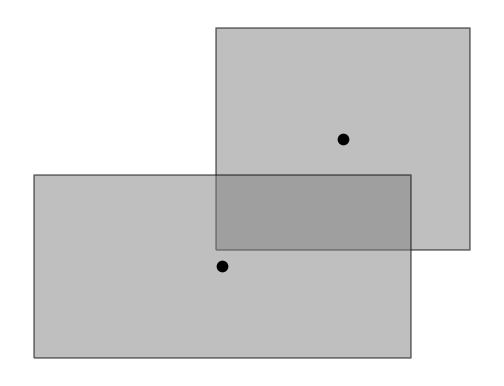

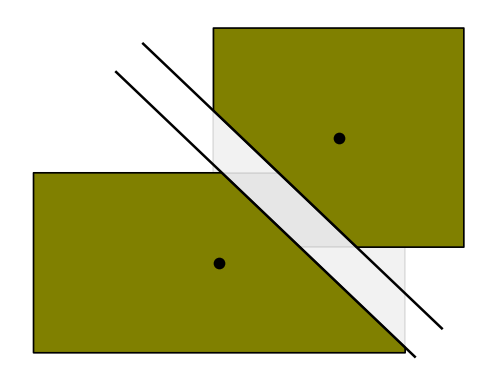

In [ ]:
inter = gdf.loc[gdf.intersects(gdf.iloc[20].geometry)]

box_A = inter.iloc[0].values[0]
box_B = inter.iloc[1].values[0]
polyA, _, lineA = slice_box(box_A, box_B, margin=10, line_mult=1.2)
polyB, _, lineB = slice_box(box_B, box_A, margin=10, line_mult=1.2)

boxes = gpd.GeoDataFrame({'geometry': [box_A, box_B]})
centroids =  gpd.GeoDataFrame({'geometry': [box_A.centroid, box_B.centroid]})
splited_boxes = gpd.GeoDataFrame({'geometry': [polyA, polyB]})
lines = gpd.GeoDataFrame({'geometry': [lineA, lineB]})

fig, ax = plt.subplots(dpi=120)
boxes.plot(ax=ax, facecolor='gray', edgecolor='k', alpha=0.5)
centroids.plot(ax=ax, c='k')
ax.axis('off');

fig, ax = plt.subplots(dpi=120)
boxes.plot(ax=ax, facecolor='gray', edgecolor='k', alpha=0.1)
splited_boxes.plot(ax=ax, facecolor='olive', edgecolor='k')
centroids.plot(ax=ax, c='k')
lines.plot(ax=ax, color='k')
ax.axis('off');

In [ ]:
#export
def intersection_list(polylist):
    r = polylist[0]
    for p in polylist:
        r = r.intersection(p)
    return r
    
def slice_one(gdf, index):
    inter = gdf.loc[gdf.intersects(gdf.iloc[index].geometry)]
    if len(inter) == 1: return inter.geometry.values[0]
    box_A = inter.loc[index].values[0]
    inter = inter.drop(index, axis=0)
    polys = []
    for i in range(len(inter)):
        box_B = inter.iloc[i].values[0]
        polyA, *_ = slice_box(box_A, box_B)
        polys.append(polyA)
    return intersection_list(polys)

def slice_all(gdf):
    polys = []
    for i in tqdm(range(len(gdf))):
        polys.append(slice_one(gdf, i))
    return gpd.GeoDataFrame({'geometry': polys})

100%|██████████| 25/25 [00:00<00:00, 556.02it/s]


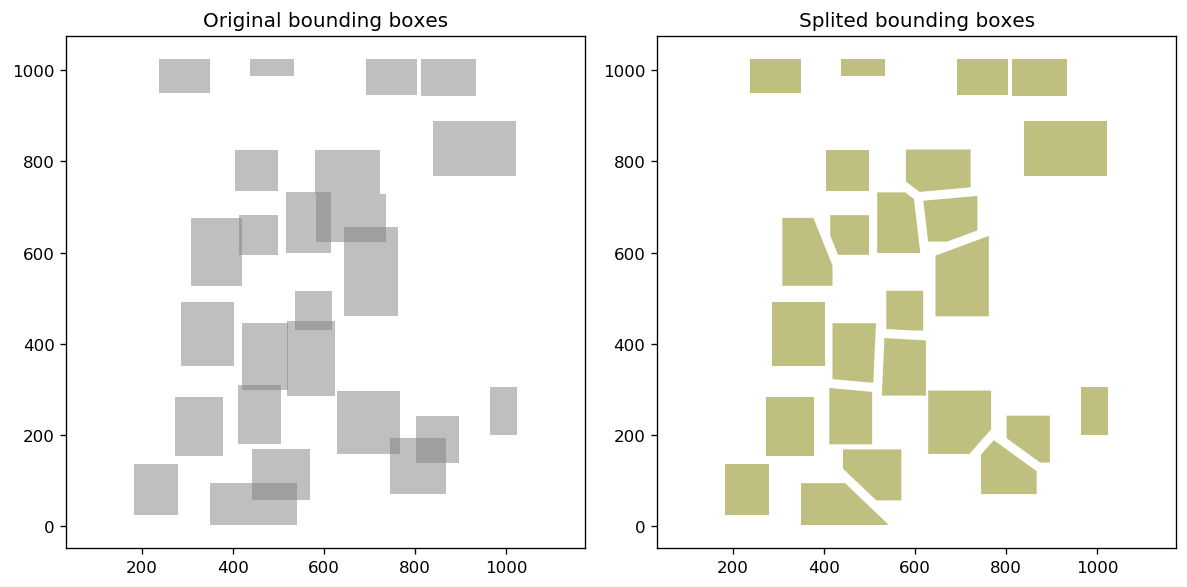

In [ ]:
res_df = slice_all(gdf)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5), dpi=120)
gdf.plot(ax=ax1, alpha=0.5, color='gray')
res_df.plot(ax=ax2, alpha=0.5, color='olive')
ax1.axis('equal')
ax2.axis('equal')
ax1.set_title('Original bounding boxes')
ax2.set_title('Splited bounding boxes')
fig.tight_layout()

In [ ]:
#hide
notebook2script()

Converted 00_core.ipynb.
Converted index.ipynb.
